<a href="https://colab.research.google.com/github/ProsperChuks/Population-Estimate-and-Projection/blob/main/forecasts/forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [147]:
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

/usr/local/bin/orca: Text file busy
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgtk2.0-0 is already the newest version (2.24.32-1ubuntu1).
libgconf-2-4 is already the newest version (3.2.6-4ubuntu1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [148]:
!pip install statsmodels --upgrade

In [149]:
!pip install pmdarima

In [150]:
import pickle
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px
import pandas as pd
import numpy as np
from pmdarima.utils import diff_inv

## Loading Models

In [151]:
wrld_forecast = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/models/pop_model.pkl', 'rb'))
cbr_forecast = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/models/cbr_model.pkl', 'rb'))
cdr_forecast = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/models/cdr_model.pkl', 'rb'))
grt_forecast = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/models/grth_model.pkl', 'rb'))

## Data

In [152]:
main_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/dataset/Population-EstimatesData.csv')

In [153]:
undiff = main_data.loc[main_data['Country Name'] == 'World']
undiff = undiff.iloc[:, 4:-1].max()
undiff = pd.DataFrame(undiff, index=undiff.index, columns=['World'])
undiff.index = pd.to_datetime(undiff.index, format='%Y')
undiff = undiff.iloc[36:]
undiff = undiff.resample('w').interpolate()
undiff.fillna(method='bfill', inplace=True)

## Projecting World's Population up to Year 2050

In [154]:
predict = wrld_forecast.forecast(2818)
predict = pd.DataFrame(predict, columns=['World'])
predict.set_index(predict.index, inplace=True)

### un-differencing the prediction

In [155]:
def inv_diff (df_orig_column, df_diff_column, periods):
  value = np.array(df_orig_column[:periods].tolist()+df_diff_column[periods:].tolist())
  inv_diff_vals = diff_inv(value, periods, 1)[periods:]
  #---------------------------------------------------------------
  value = np.array(df_orig_column[:periods].tolist()+inv_diff_vals[periods:].tolist())
  inv_diff_vals = diff_inv(value, periods, 1)[periods:]
  global idv
  idv = pd.DataFrame(inv_diff_vals)
  return inv_diff_vals

inv_diff(undiff.World, predict.World, 6000)

pred = idv.rename(columns={0: 'World'})
pred.set_index(predict.index, inplace=True)

In [156]:
pop = pred
pop.rename(columns={'World': 'Population'}, inplace=True)

### Plotting the Prediction

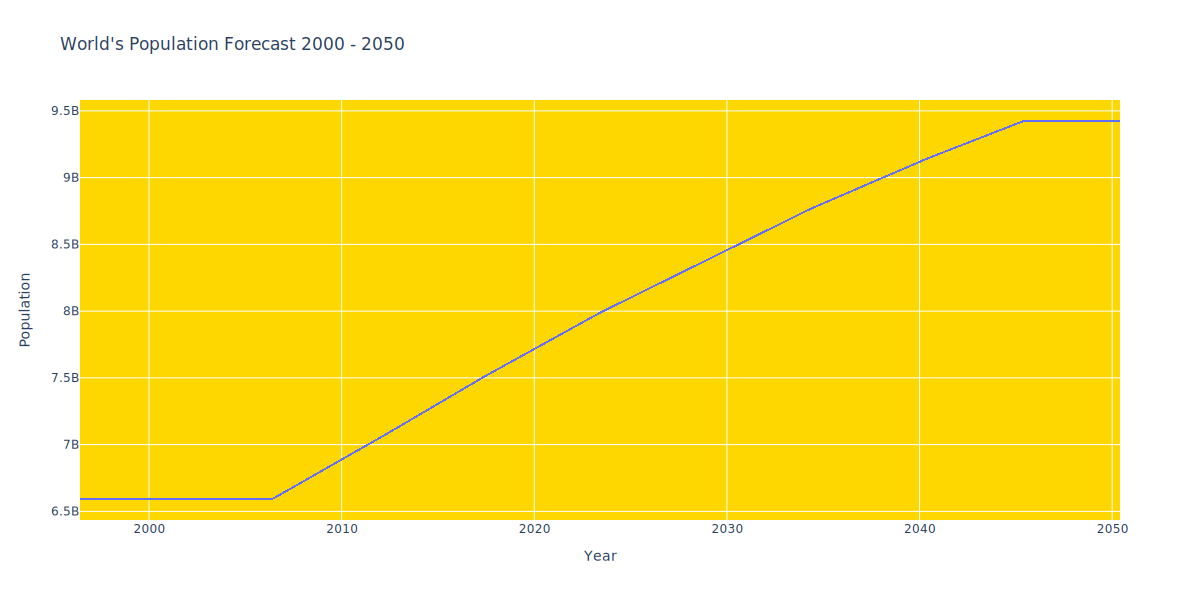

In [157]:
fig = px.line(pred, pred.index, 'Population', 
        labels={'x':'Year', 'World': 'Population Count'},
        title='World\'s Population Forecast 2000 - 2050')

fig.update_layout(plot_bgcolor='gold')
fig.show('svg', height=600, width=1200)
fig.write_html('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/Interactive plots/population prediction.html')

## Forecasting World's Population Growth rate up to Year 2060

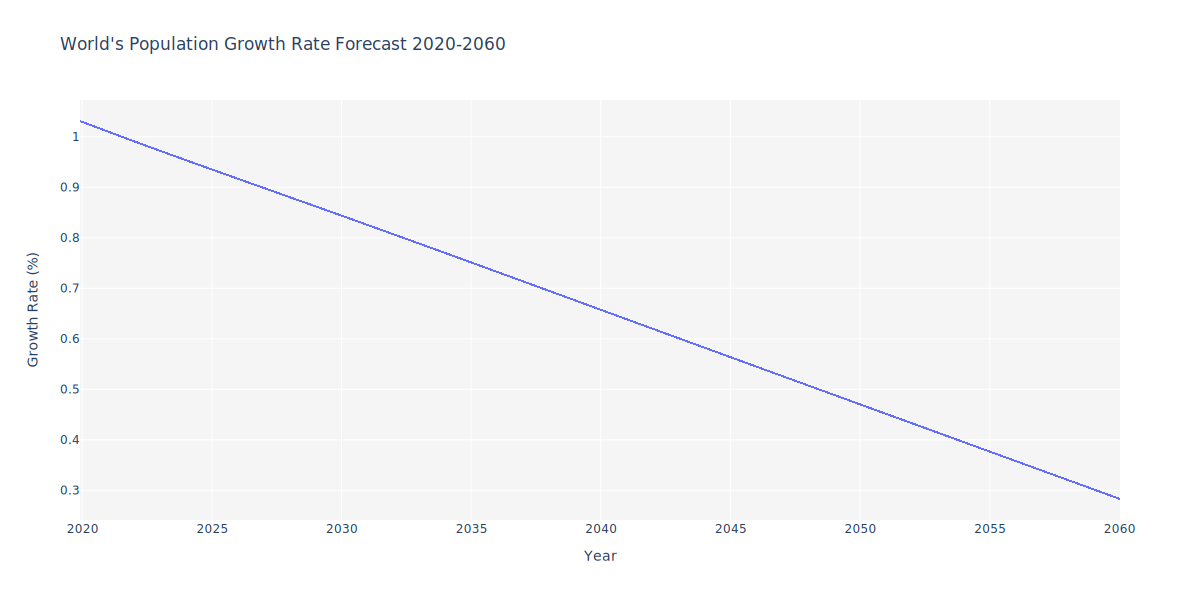

In [158]:
predict = grt_forecast.predict(start=3230, end=5323)
predict = pd.DataFrame(predict, index=predict.index)

fig = px.line(predict, predict.index, predict[0],
        labels={'x':'Year', '0': 'Growth Rate (%)'},
        title='World\'s Population Growth Rate Forecast 2020-2060')

fig.update_layout(plot_bgcolor='whitesmoke')
fig.show('svg', height=600, width=1200)
fig.write_html('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/Interactive plots/growth prediction.html')

In [159]:
grt = predict
grt.rename(columns={0: 'Population Growth Rate'}, inplace=True)

## Forecasting Crude Birth Rate(Per 1000 Persons) up to Year 2060

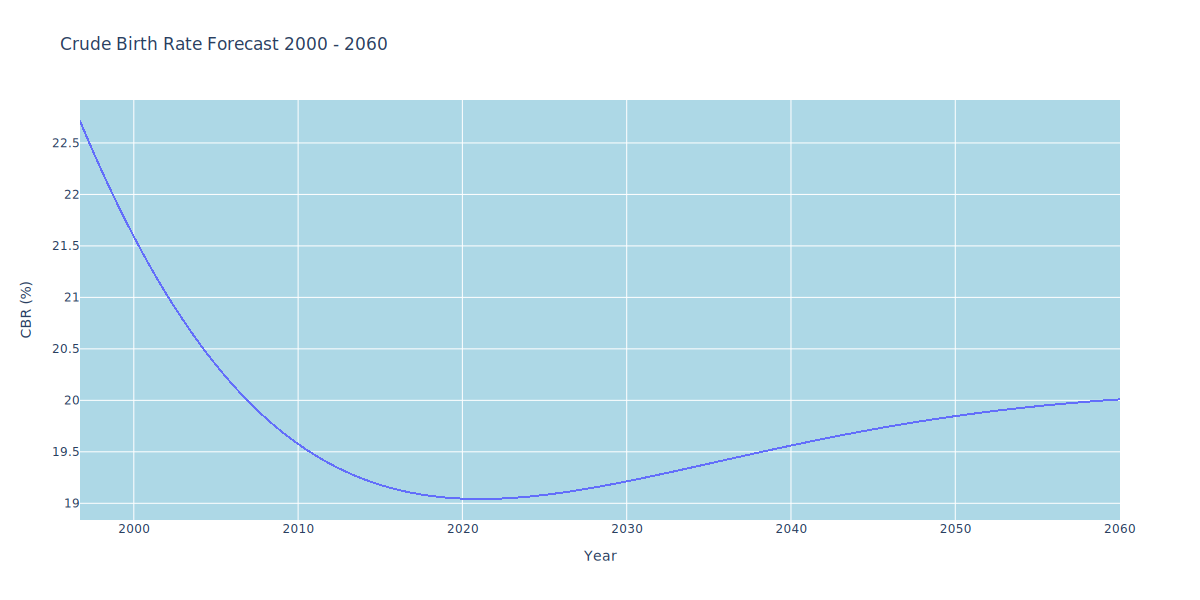

In [160]:
predict = cbr_forecast.predict(start=2020, end=5323)
predict = pd.DataFrame(predict, index=predict.index)

fig = px.line(predict, predict.index, predict.predicted_mean,
        labels={'x':'Year', 'predicted_mean': 'CBR (%)'},
        title='Crude Birth Rate Forecast 2000 - 2060')

fig.update_layout(plot_bgcolor='lightblue')
fig.show('svg', height=600, width=1200)
fig.write_html('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/Interactive plots/cbr prediction.html')

In [161]:
cbr = predict
cbr.rename(columns={'predicted_mean': 'CBR'}, inplace=True)

## Forecasting Crude Death Rate(Per 1000 Persons) up to Year 2060

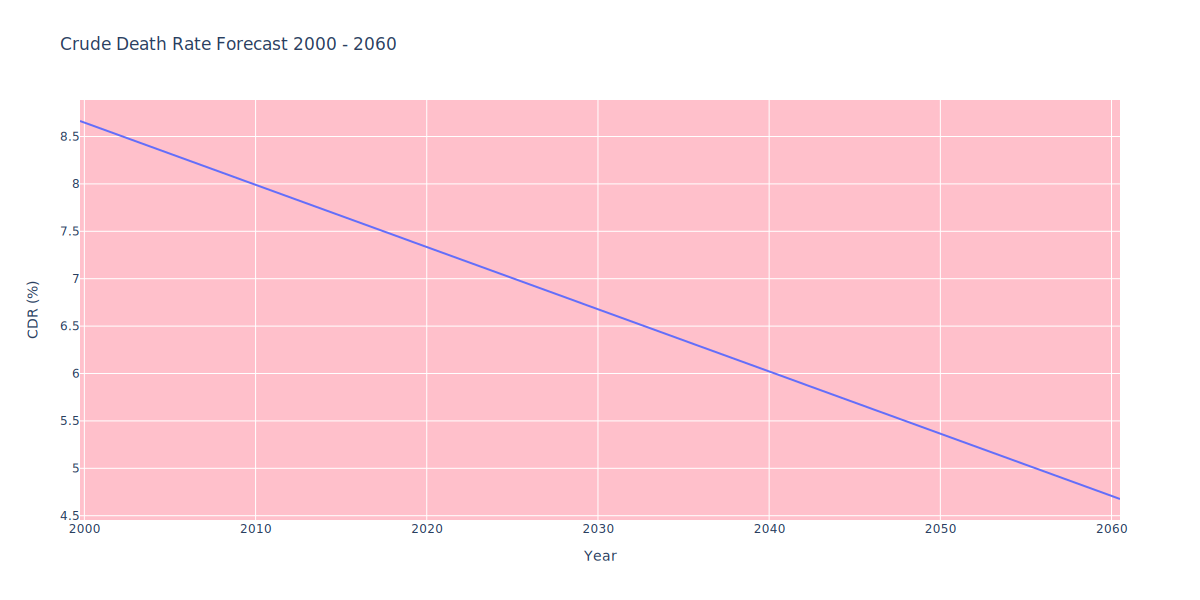

In [162]:
predict = cdr_forecast.forecast(730)

fig = px.line(predict, predict.index, 0, 
        labels={'x':'Year', '0': 'CDR (%)'},
        title='Crude Death Rate Forecast 2000 - 2060')

fig.update_layout(plot_bgcolor='pink')
fig.show('svg', height=600, width=1200)
fig.write_html('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/Interactive plots/cdr prediction.html')

In [163]:
cdr = pd.DataFrame(predict, columns=['CDR'])

## Extracting Projections

In [164]:
pop = pop.resample('a').max().iloc[25:]
grt = grt.resample('a').max().iloc[2:]
cbr = cbr.resample('a').max().iloc[25:]
cdr = cdr.resample('a').max().iloc[22:]

In [165]:
v1 = pd.concat([grt, cbr], axis=1)
v2 = pd.concat([v1, cdr], axis=1)
final = pd.concat([pop, v2.iloc[0:30, :]], axis=1)
final.rename(columns={'Population': 'World Population', 
                      'Population Growth Rate': 'Yearly Change %'}, inplace=True)

In [166]:
final['Yearly Change %'] = round(final['Yearly Change %'], 2)
final['CBR'] = round(final['CBR'], 2)
final['CDR'] = round(final['CDR'], 2)
final
final.to_csv('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/World Population Projections.csv')